In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency, norm, ttest_rel
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

In [ ]:
important_columns = ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'MaxH', 'MaxD', 'MaxA']
columns_to_rename = {
    'Date': 'date',
    'Time': 'time',
    'HomeTeam': 'home_team',
    'AwayTeam': 'away_team',
    'FTHG': 'full_time_home_goals',
    'FTAG': 'full_time_away_goals',
    'FTR': 'full_time_result',
    'HTHG': 'first_half_home_goals',
    'HTAG': 'first_half_away_goals',
    'HTR': 'first_half_result',
    'HS': 'home_shots',
    'AS': 'away_shots',
    'HST': 'home_target_shots',
    'AST': 'away_target_shots',
    'HF': 'fouls_home',
    'AF': 'fouls_away',
    'HC': 'corners_home',
    'AC': 'corners_away',
    'HY': 'yellow_cards_home',
    'AY': 'yellow_cards_away',
    'HR': 'red_cards_home',
    'AR': 'red_cards_away',
    'MaxH': 'max_odds_home_win',
    'MaxD': 'max_odds_draw',
    'MaxA': 'maximum_odds_away_win'
}



def five_years_ligue_history(ligue_urls):
    """создает датасет с данными из конкретной футбольной лиги"""

    five_years_history = pd.DataFrame()
    for url in ligue_urls:
        ligue_data = pd.read_csv(url, sep=',')

        ligue_important_data = ligue_data[important_columns]

        five_years_history = pd.concat([five_years_history, ligue_important_data], axis=0)

    five_years_history.reset_index(inplace=True, drop=True)
    five_years_history.rename(columns=columns_to_rename, inplace=True)
    five_years_history['date'] = pd.to_datetime(five_years_history['date'], format='mixed')

    return five_years_history

In [ ]:
def find_2clubs_confr_history(some_data, club1, club2):
    """ищет историю игр между двумя клубами"""
    history = some_data[((some_data['home_team'] == club1) & (some_data['away_team'] == club2)) |
        ((some_data['home_team'] == club2) & (some_data['away_team'] == club1))]
    history.reset_index(drop=True, inplace=True)
    return history

In [ ]:
def find_club_match_history(some_data, club):
    """ищет историю игр конкретного клуба"""

    history = some_data[(some_data['home_team'] == club) | (some_data['away_team'] == club)]
    history.reset_index(drop=True, inplace=True)
    return history

In [ ]:
def find_avg_points_history(some_data, club):
    """ищет среднее количество очков клуба"""


    history = find_club_match_history(some_data, club)
    sum_points = len(history[(history['home_team'] == club) & (history['full_time_result'] == 'H')]) * 3 \
        + len(history[(history['away_team'] == club) & (history['full_time_result'] == 'A')]) * 3 \
        + len(history[(history['home_team'] == club) & (history['full_time_result'] == 'D')]) \
        + len(history[(history['away_team'] == club) & (history['full_time_result'] == 'D')])

    return sum_points / len(history)


In [ ]:
def first_and_last_time_results(some_data, club):
    """сравнивает количество голов за первый тайм и за второй (или насколько клуб играет лучше во втором тайме)"""

    history = find_club_match_history(some_data, club)

    avg_first_time = (history[history['home_team'] == club]['first_half_home_goals'].sum() \
                      + history[history['away_team'] == club]['first_half_away_goals'].sum()) / len(history)


    avg_last_time = (history[history['home_team'] == club]['full_time_home_goals'].sum() \
                      + history[history['away_team'] == club]['full_time_away_goals'].sum()) / len(history) - avg_first_time

    return avg_first_time, avg_last_time

In [ ]:
def compare_home_away_fouls_cards_ratio(some_data):
    """ищет предвзятость судей на домашнем стадионе в лиге и возвращает соотношение фолов и карточек для домашней и гостевой команд"""

    fouls_home = some_data['fouls_home'].sum()
    fouls_away = some_data['fouls_away'].sum()

    cards_home = (some_data['yellow_cards_home'] + some_data['red_cards_home']).sum()
    cards_away = (some_data['yellow_cards_away'] + some_data['red_cards_away']).sum()

    home_ratio = fouls_home / cards_home
    away_ratio = fouls_away / cards_away

    return home_ratio, away_ratio

In [ ]:
def find_home_away_goals_ratio(some_data):
    """ищет соотношение ударов и голов для домашних и гостевых команд в заданной лиге"""

    goals_home = some_data['first_half_home_goals'].sum()
    goals_away = some_data['first_half_away_goals'].sum()

    shots_home = some_data['home_target_shots'].sum()
    shots_away = some_data['away_target_shots'].sum()

    home_ratio = shots_home / goals_home
    away_ratio = shots_away / goals_away

    return home_ratio, away_ratio

In [ ]:
def realization_ratio(some_data):
    """ищет % реализации ударов по воротам для домашних и гостевых команд в заданной лиге"""

    goals_home = some_data['first_half_home_goals']
    goals_away = some_data['first_half_away_goals']

    shots_home = some_data['home_target_shots']
    shots_away = some_data['away_target_shots']

    shots_home[shots_home == 0] = 1
    shots_away[shots_away == 0] = 1

    home_ratio = goals_home / shots_home
    away_ratio = goals_away / shots_away

    return home_ratio, away_ratio

In [ ]:
def find_avg_goals_5_matches(some_data, club_name):
    'ищет среднее количество голов за 5 '
    club = find_club_match_history(some_data, club_name)
    club_away_goals = club[club['away_team'] == club_name][['date', 'full_time_away_goals']]
    club_away_goals_ser = club_away_goals['full_time_away_goals']
    club_away_goals_ser.index = club_away_goals['date']


    club_home_goals = club[club['home_team'] == club_name][['date', 'full_time_home_goals']]
    club_home_goals_ser = club_home_goals['full_time_home_goals']
    club_home_goals_ser.index = club_home_goals['date']



    club_data = pd.concat([club_home_goals_ser, club_away_goals_ser])
    club_data = club_data.sort_index()

    mean_5_club = club_data.rolling(window=5, min_periods=5).mean()

    return mean_5_club

In [ ]:
def draw_everything(some_df):
    """рисует гистограмму побед хозяев и гостей, гиаграмму рассеяния (голы хозяев vs. голы гостей),
    гистограмму количества голов за матч, гистограмма правильных прогнозов"""
    some_df['match_result'] = some_df.apply(lambda row: 'Home Win' if row['full_time_result'] == 'H'
                                  else ('Away Win' if row['full_time_result'] == 'A'
                                        else 'Draw'), axis=1)

    # 1. Гистограмма побед хозяев и гостей
    win_counts = some_df['match_result'].value_counts()

    plt.figure(figsize=(6, 4))
    win_counts[['Home Win', 'Away Win']].plot(kind='bar', color=['blue', 'red'])
    plt.title("Number of Home and Away Wins")
    plt.xlabel("Match Result")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # 2. Диаграмма рассеяния (голы хозяев vs. голы гостей)
    plt.figure(figsize=(6, 6))
    plt.scatter(some_df['full_time_home_goals'], some_df['full_time_away_goals'], alpha=0.6)
    plt.xlabel("Home Team Goals")
    plt.ylabel("Away Team Goals")
    plt.title("Scatter Plot of Home vs. Away Goals")
    plt.grid(True)
    plt.show()

    # 3. Гистограмма количества голов за матч
    match_goals = some_df['full_time_home_goals'] +	some_df['full_time_away_goals']

    plt.figure(figsize=(6, 4))
    plt.hist(match_goals, bins=9,color="skyblue", edgecolor="black")
    plt.xlabel("Amount of Goals")
    plt.ylabel("Frequency")
    plt.title("Summary match goals distribution")




    # 4. Гистограмма правильных прогнозов
    some_df['predicted_result'] = some_df.apply(lambda row: 'Home Win' if row['max_odds_home_win'] < row['max_odds_draw'] and row['max_odds_home_win'] < row['maximum_odds_away_win']
                                          else ('Away Win' if row['maximum_odds_away_win'] < row['max_odds_home_win'] and row['maximum_odds_away_win'] < row['max_odds_draw']
                                                else 'Draw'), axis=1)

    some_df['correct_prediction'] = (some_df['match_result'] == some_df['predicted_result']).astype(int)

    plt.figure(figsize=(6, 4))
    some_df['correct_prediction'].value_counts().sort_index().plot(kind='bar', color=['red', 'green'])
    plt.xticks([0, 1], ['Incorrect', 'Correct'], rotation=0)
    plt.title("Histogram of Correct Predictions Based on Odds")
    plt.xlabel("Prediction Accuracy")
    plt.ylabel("Count")
    plt.show()


    # 5. Гистограмма голов в первом и втором тайме
    first = []
    second = []
    for i in np.unique(some_df['away_team']):
        avg_first_time, avg_last_time = first_and_last_time_results(some_df, i)
        first.append(avg_first_time)
        second.append(avg_last_time)
    x = np.array(first).mean()
    y = np.array(second).mean()
    labels = ['First', 'Second']
    values = [x, y]
    plt.bar(labels, values, color=['blue', 'red'])
    plt.title("Histogram goals in the first and second time")
    plt.xlabel("Time")
    plt.ylabel("Goals")
    plt.show()




In [ ]:
eng_urls = ['https://www.football-data.co.uk/mmz4281/2021/E0.csv', 'https://www.football-data.co.uk/mmz4281/2122/E0.csv',
            'https://www.football-data.co.uk/mmz4281/2223/E0.csv', 'https://www.football-data.co.uk/mmz4281/2324/E0.csv',
           'https://www.football-data.co.uk/mmz4281/2425/E0.csv']
eng_data = five_years_ligue_history(eng_urls)
eng_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2020-12-09,12:30,Fulham,Arsenal,0,3,A,0,1,A,...,12,2,3,2,2,0,0,6.55,4.55,1.60
1,2020-12-09,15:00,Crystal Palace,Southampton,1,0,H,1,0,H,...,11,7,3,2,1,0,0,3.36,3.36,2.50
2,2020-12-09,17:30,Liverpool,Leeds,4,3,H,3,2,H,...,6,9,0,1,0,0,0,1.35,6.50,10.75
3,2020-12-09,20:00,West Ham,Newcastle,0,2,A,0,0,D,...,7,8,7,2,2,0,0,2.24,3.70,3.60
4,2020-09-13,14:00,West Brom,Leicester,0,3,A,0,0,D,...,9,2,5,1,1,0,0,4.00,3.82,2.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,2025-08-03,20:00,Wolves,Everton,1,1,D,1,1,D,...,16,5,5,2,2,0,0,2.71,3.31,2.95
1797,2025-09-03,14:00,Chelsea,Leicester,1,0,H,0,0,D,...,13,12,2,1,0,0,0,1.22,8.40,15.50
1798,2025-09-03,14:00,Tottenham,Bournemouth,2,2,D,0,1,A,...,16,3,6,3,3,0,0,2.79,3.98,2.45
1799,2025-09-03,16:30,Man United,Arsenal,1,1,D,1,0,H,...,11,2,9,0,1,0,0,6.00,3.81,1.75


In [ ]:
eng_data.isna().sum()
## пропусков в данных нет

,0
date,0
time,0
home_team,0
away_team,0
full_time_home_goals,0
full_time_away_goals,0
full_time_result,0
first_half_home_goals,0
first_half_away_goals,0
first_half_result,0


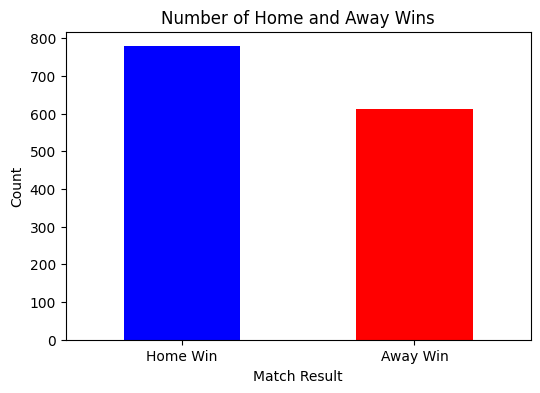

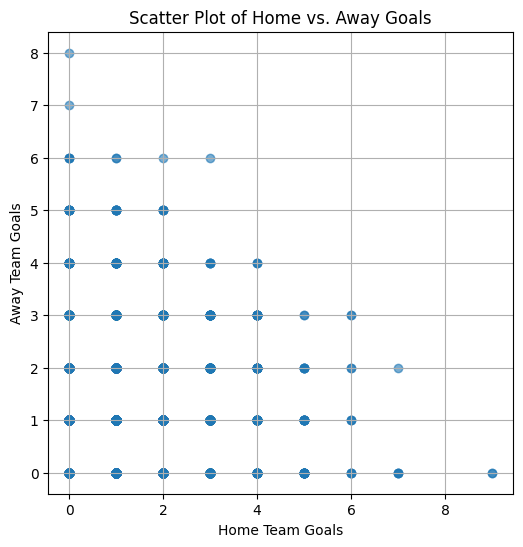

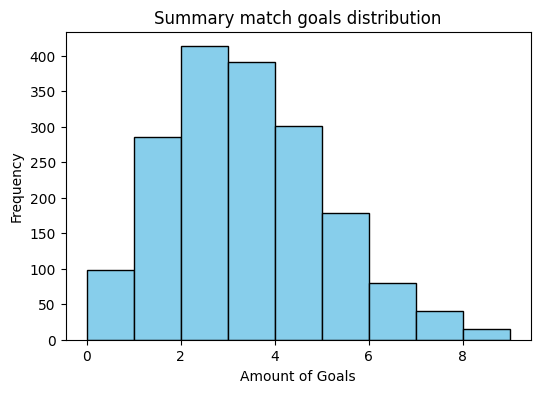

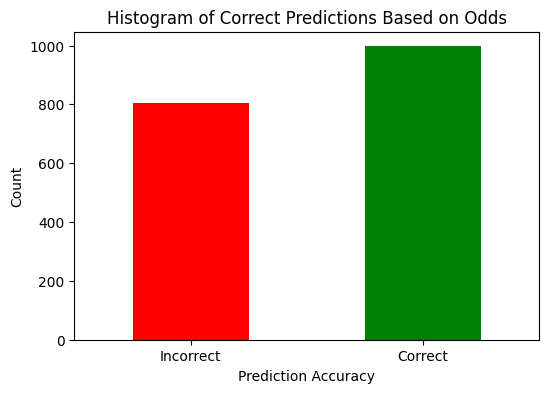

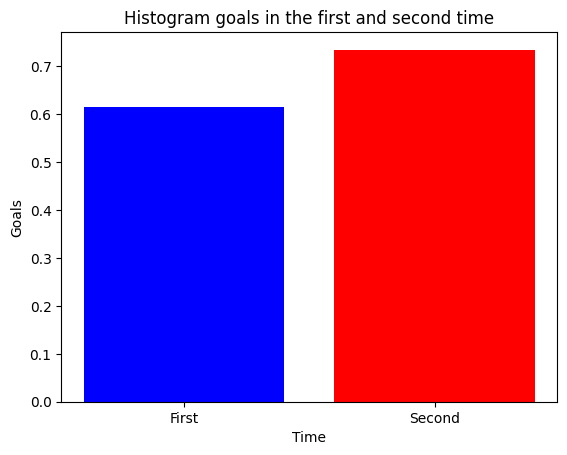

In [ ]:
df = eng_data.copy(deep=True)
draw_everything(df)

In [ ]:
ger_urls = ['https://www.football-data.co.uk/mmz4281/2021/D1.csv', 'https://www.football-data.co.uk/mmz4281/2122/D1.csv',
           'https://www.football-data.co.uk/mmz4281/2223/D1.csv', 'https://www.football-data.co.uk/mmz4281/2324/D1.csv',
           'https://www.football-data.co.uk/mmz4281/2425/D1.csv']
ger_data = five_years_ligue_history(ger_urls)
ger_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2020-09-18,19:30,Bayern Munich,Schalke 04,8,0,H,3,0,H,...,12,9,2,1,2,0,0,1.15,14.00,34.00
1,2020-09-19,14:30,Ein Frankfurt,Bielefeld,1,1,D,0,0,D,...,13,14,3,2,2,0,0,1.71,4.50,5.25
2,2020-09-19,14:30,FC Koln,Hoffenheim,2,3,A,1,2,A,...,13,1,6,0,0,0,0,2.70,3.88,2.69
3,2020-09-19,14:30,Stuttgart,Freiburg,2,3,A,0,2,A,...,16,7,2,2,2,0,0,2.33,3.70,3.35
4,2020-09-19,14:30,Union Berlin,Augsburg,1,3,A,0,1,A,...,9,8,1,2,0,0,0,2.45,3.38,3.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,2025-08-03,14:30,Leverkusen,Werder Bremen,0,2,A,0,1,A,...,10,10,3,4,4,0,0,1.28,6.80,12.00
1445,2025-08-03,14:30,Wolfsburg,St Pauli,1,1,D,0,1,A,...,13,6,6,1,0,0,0,1.81,3.88,5.00
1446,2025-08-03,17:30,Freiburg,RB Leipzig,0,0,D,0,0,D,...,11,2,6,0,3,0,0,2.67,3.40,2.86
1447,2025-09-03,14:30,Ein Frankfurt,Union Berlin,1,2,A,1,0,H,...,8,1,5,3,0,0,0,1.78,4.22,4.75


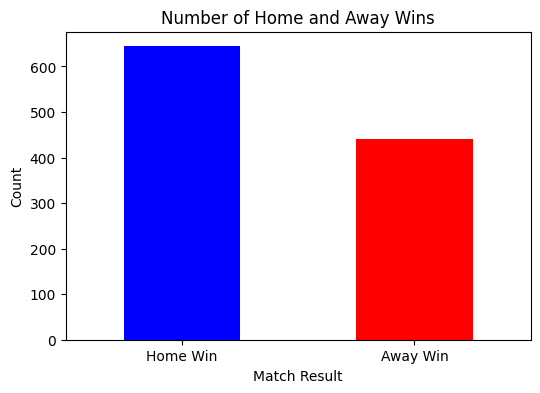

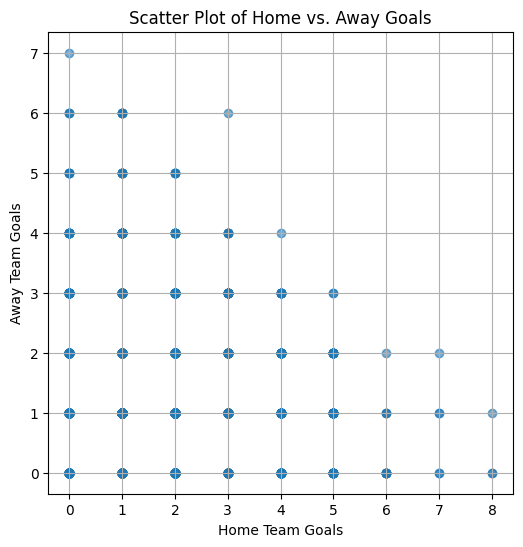

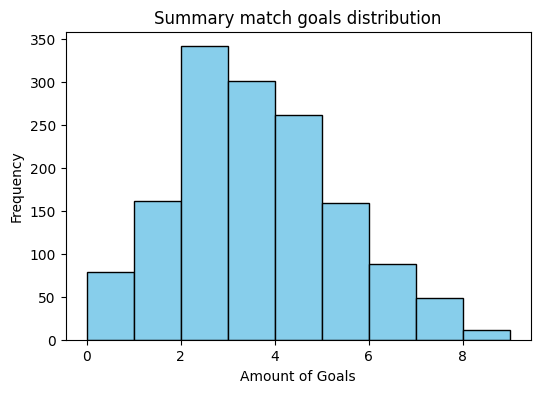

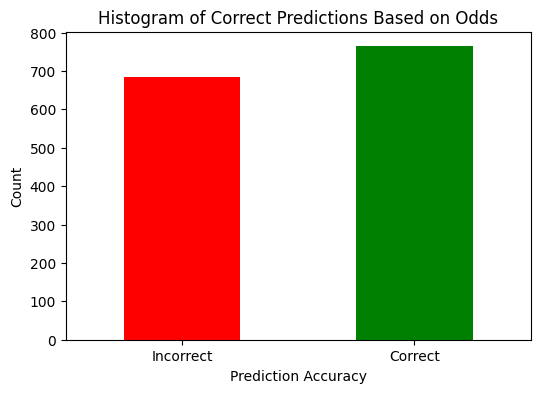

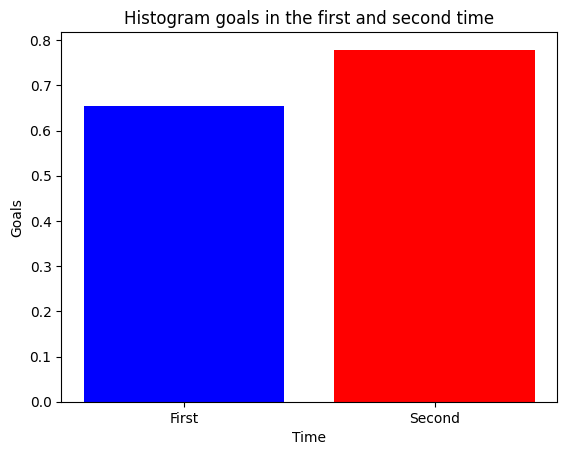

In [ ]:
df_1 = ger_data.copy(deep=True)
draw_everything(df_1)

In [ ]:
spain_urls = ['https://www.football-data.co.uk/mmz4281/2021/SP1.csv', 'https://www.football-data.co.uk/mmz4281/2122/SP1.csv',
             'https://www.football-data.co.uk/mmz4281/2223/SP1.csv', 'https://www.football-data.co.uk/mmz4281/2324/SP1.csv',
             'https://www.football-data.co.uk/mmz4281/2425/SP1.csv'
             ]
spain_data = five_years_ligue_history(spain_urls)
spain_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2020-12-09,15:00,Eibar,Celta,0,0,D,0,0,D,...,13,3,3,4,4,1,0,2.66,3.27,3.13
1,2020-12-09,17:30,Granada,Ath Bilbao,2,0,H,0,0,D,...,10,1,2,3,4,0,0,2.92,3.22,2.89
2,2020-12-09,20:00,Cadiz,Osasuna,0,2,A,0,1,A,...,21,6,2,2,2,0,0,2.93,3.08,2.97
3,2020-09-13,13:00,Alaves,Betis,0,1,A,0,0,D,...,17,6,4,3,3,0,0,2.99,3.35,2.76
4,2020-09-13,15:00,Valladolid,Sociedad,1,1,D,1,0,H,...,17,5,3,4,1,0,0,3.04,3.38,2.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,2025-09-03,15:15,Real Madrid,Vallecano,2,1,H,2,1,H,...,17,4,6,3,1,0,0,1.31,6.50,11.00
1784,2025-09-03,17:30,Ath Bilbao,Mallorca,1,1,D,0,0,D,...,13,3,3,1,3,0,0,1.66,3.98,6.50
1785,2025-09-03,17:30,Betis,Las Palmas,1,0,H,0,0,D,...,14,11,1,2,8,0,1,1.48,4.83,7.50
1786,2025-09-03,20:00,Sociedad,Sevilla,0,1,A,0,0,D,...,12,6,3,2,1,0,0,2.30,3.29,3.70


In [ ]:
spain_data.isna().sum()
## пропусков в данных нет

,0
date,0
time,0
home_team,0
away_team,0
full_time_home_goals,0
full_time_away_goals,0
full_time_result,0
first_half_home_goals,0
first_half_away_goals,0
first_half_result,0


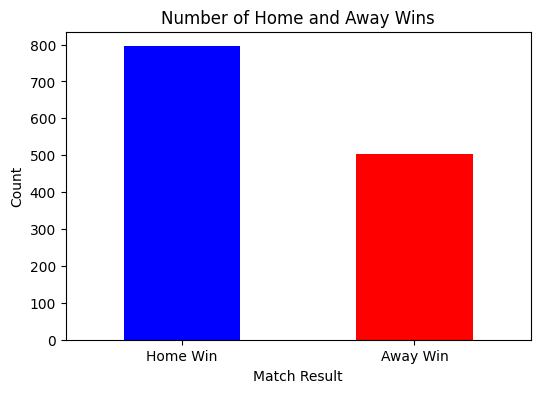

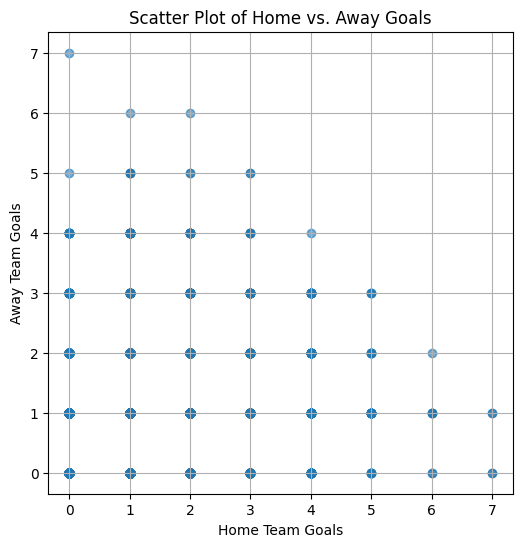

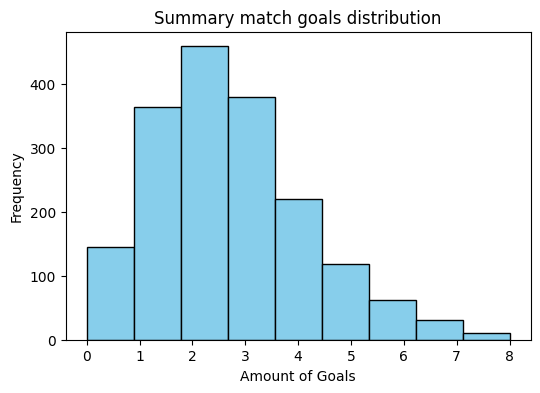

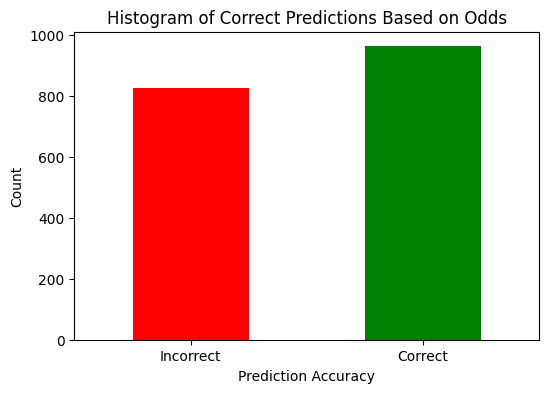

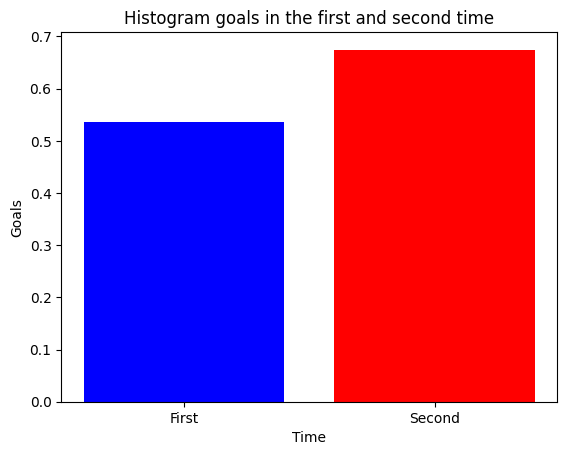

In [ ]:
df_2 = spain_data.copy(deep=True)
draw_everything(df_2)

In [ ]:
italy_urls = ['https://www.football-data.co.uk/mmz4281/2021/I1.csv', 'https://www.football-data.co.uk/mmz4281/2122/I1.csv',
             'https://www.football-data.co.uk/mmz4281/2223/I1.csv', 'https://www.football-data.co.uk/mmz4281/2324/I1.csv',
             'https://www.football-data.co.uk/mmz4281/2425/I1.csv']
italy_data = five_years_ligue_history(italy_urls)
italy_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2020-09-19,17:00,Fiorentina,Torino,1,0,H,0,0,D,...,20,4,1,3,1,0,0,1.94,3.85,4.60
1,2020-09-19,19:45,Verona,Roma,0,0,D,0,0,D,...,20,0,6,2,0,0,0,4.00,3.81,2.08
2,2020-09-20,11:30,Parma,Napoli,0,2,A,0,0,D,...,12,4,2,4,1,0,0,5.80,4.52,1.67
3,2020-09-20,14:00,Genoa,Crotone,4,1,H,3,1,H,...,14,6,4,4,2,0,0,1.98,3.80,4.35
4,2020-09-20,17:00,Sassuolo,Cagliari,1,1,D,0,0,D,...,18,7,3,1,3,0,0,2.00,3.98,3.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2025-09-03,11:30,Verona,Bologna,1,2,A,0,1,A,...,11,1,3,2,1,1,0,5.30,3.60,1.84
1796,2025-09-03,14:00,Napoli,Fiorentina,2,1,H,1,0,H,...,5,4,4,1,2,0,0,1.63,4.25,6.60
1797,2025-09-03,17:00,Empoli,Roma,0,1,A,0,1,A,...,10,1,9,0,0,0,0,4.08,3.60,2.07
1798,2025-09-03,19:45,Juventus,Atalanta,0,4,A,0,1,A,...,11,2,5,1,1,0,0,2.64,3.33,2.98


In [ ]:
italy_data.isna().sum()
## пропуски в данных есть, данные числовые, так что заполним их средними значениями
#italy_data.fillna(italy_data.mean(), inplace=True)

,0
date,0
time,0
home_team,0
away_team,0
full_time_home_goals,0
full_time_away_goals,0
full_time_result,0
first_half_home_goals,0
first_half_away_goals,0
first_half_result,0


In [ ]:
italy_data[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win']].fillna( \
        italy_data[['max_odds_home_win', 'max_odds_draw', 'maximum_odds_away_win']].mean(), inplace=True)

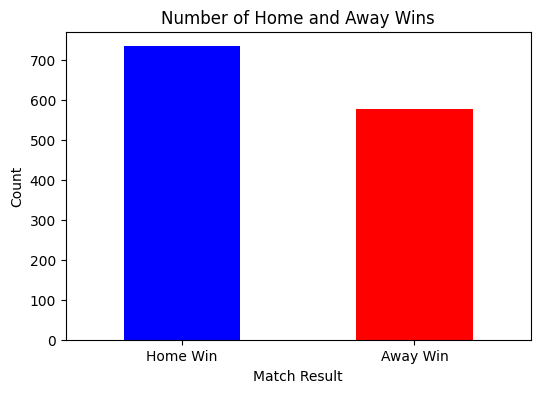

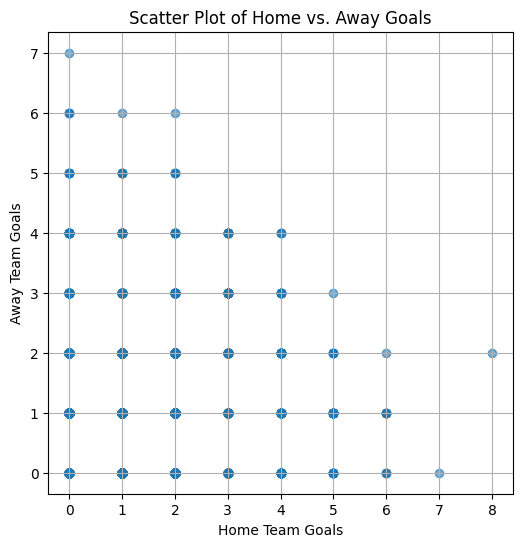

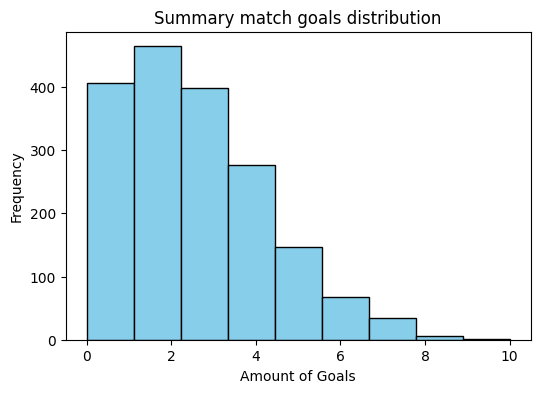

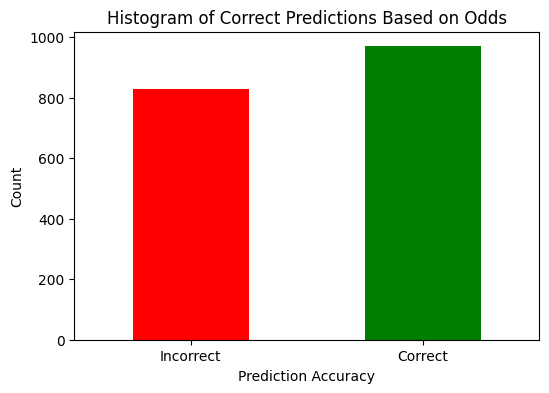

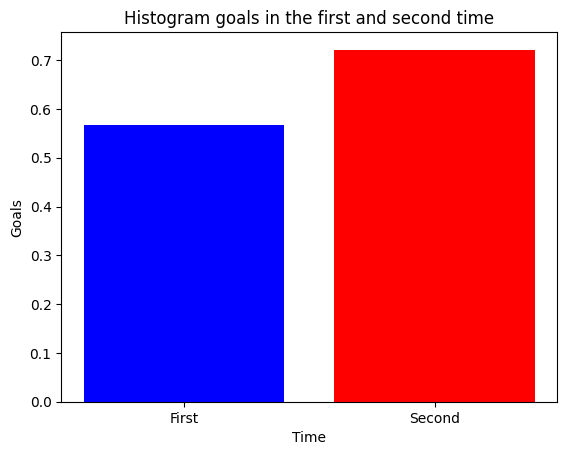

In [ ]:
df_3 = italy_data.copy(deep=True)
draw_everything(df_3)

In [ ]:
france_urls = ['https://www.football-data.co.uk/mmz4281/2021/F1.csv', 'https://www.football-data.co.uk/mmz4281/2122/F1.csv',
                'https://www.football-data.co.uk/mmz4281/2223/F1.csv', 'https://www.football-data.co.uk/mmz4281/2324/F1.csv',
                'https://www.football-data.co.uk/mmz4281/2425/F1.csv']
france_data = five_years_ligue_history(france_urls)
france_data

,date,time,home_team,away_team,full_time_home_goals,full_time_away_goals,full_time_result,first_half_home_goals,first_half_away_goals,first_half_result,...,fouls_away,corners_home,corners_away,yellow_cards_home,yellow_cards_away,red_cards_home,red_cards_away,max_odds_home_win,max_odds_draw,maximum_odds_away_win
0,2020-08-21,18:00,Bordeaux,Nantes,0,0,D,0,0,D,...,15,2,3,2,3,1,0,2.59,3.13,3.38
1,2020-08-22,16:00,Dijon,Angers,0,1,A,0,1,A,...,8,3,9,0,0,0,0,2.86,3.22,2.92
2,2020-08-22,20:00,Lille,Rennes,1,1,D,1,0,H,...,16,4,2,0,1,1,1,2.38,3.34,3.60
3,2020-08-23,12:00,Monaco,Reims,2,2,D,1,2,A,...,14,8,1,1,3,0,0,2.00,3.65,4.50
4,2020-08-23,14:00,Lorient,Strasbourg,3,1,H,0,1,A,...,10,6,1,3,2,0,0,2.75,3.32,3.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,2025-09-03,14:00,Brest,Angers,2,0,H,1,0,H,...,8,6,6,1,1,0,0,1.80,3.92,5.00
1667,2025-09-03,16:15,Le Havre,St Etienne,1,1,D,1,1,D,...,17,5,6,2,3,0,0,2.40,3.74,3.10
1668,2025-09-03,16:15,Nantes,Strasbourg,0,1,A,0,0,D,...,17,3,9,1,1,0,0,2.68,3.52,2.83
1669,2025-09-03,16:15,Reims,Auxerre,0,2,A,0,2,A,...,13,6,12,1,1,0,0,2.55,3.52,3.01


In [ ]:
france_data.isna().sum()
## пропусков в данных нет

,0
date,0
time,0
home_team,0
away_team,0
full_time_home_goals,0
full_time_away_goals,0
full_time_result,0
first_half_home_goals,0
first_half_away_goals,0
first_half_result,0


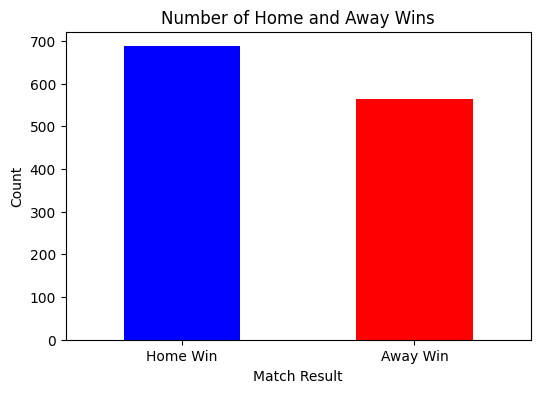

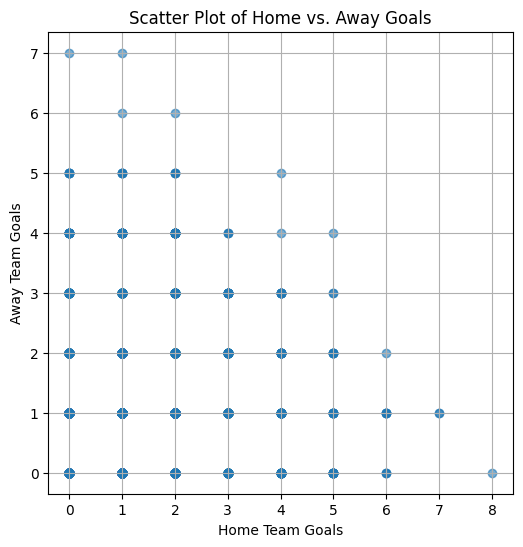

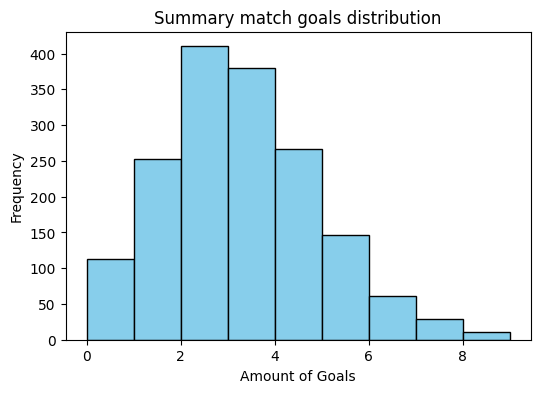

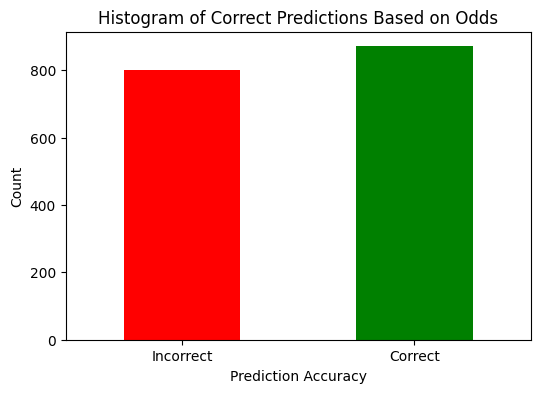

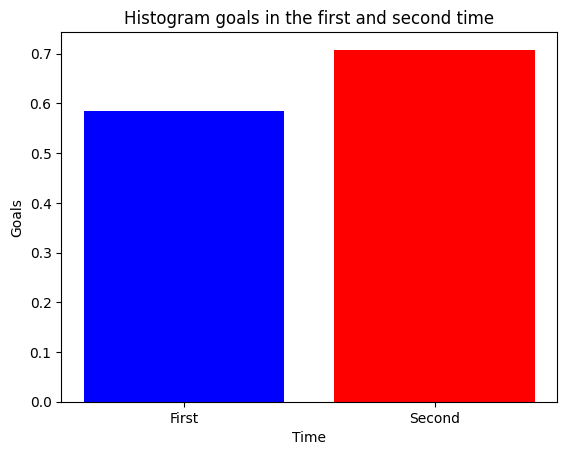

In [ ]:
df_4 = france_data.copy(deep=True)
draw_everything(df_4)

## Проверка гипотез

{'whiskers': [<matplotlib.lines.Line2D at 0x7d1393745190>,
 'caps': [<matplotlib.lines.Line2D at 0x7d13937478d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d13937acb10>],
 'medians': [<matplotlib.lines.Line2D at 0x7d1393745710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d1393760510>],
 'means': []}

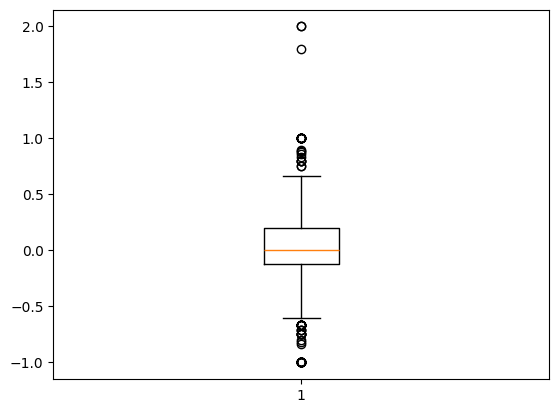

In [ ]:
leagues = [eng_data, ger_data, spain_data, italy_data, france_data]

spain_realization_home, spain_realization_away = realization_ratio(spain_data)
dif_dist = spain_realization_home - spain_realization_away
plt.boxplot(dif_dist)

Выбросов уж больно много! Мы крайне этим огорчены. В среднем, конечно, ноль голов, поэтому и соотношение оказывается нулевым. Либо результаты ничейные, и команды, собственно, одинаково все реализуют, поэтому все аналогично сводится в ноль.

Там есть странные ситуации, где соотношение > 1, это связано с автоголами, либо вызвано условностью правил, когда удар с пенальти не считается за удар в створ. Поэтому и происходит такое.

## Проверка гипотезы: команды в Английской лиге выйгрывают чаще дома, чем в гостях(без ничьих)
Нулевая гипотеза: p_home = p_away = 0.5  
Альтернативная гипотеза: p_home > p_away



In [ ]:
win_home = (eng_data['full_time_result'] == 'H').astype('int32')
win_away = (eng_data['full_time_result'] == 'A').astype('int32')
win_home

,full_time_result
0,0
1,1
2,1
3,0
4,0
...,...
1796,0
1797,1
1798,0
1799,0


In [ ]:
# Z-тест для пропорций (без учета ничьих)
total_matches_with_result = win_home.sum() + win_away.sum()  # матчи с победой
successes = win_home.sum()  # домашние победы

# Нулевая гипотеза: p_home = p_away = 0.5

z_stat, p_value = proportions_ztest(
    count=successes, nobs=total_matches_with_result,value=0.5,
    alternative='larger'  # проверяем, что p_home > 0.5
)

print(f"Z-тест (без ничьих):\nZ-статистика = {z_stat:.2f}, p-value = {p_value:.5f}\n")

alpha = 0.05
if p_value < alpha:
    print("- Z-тест: домашние победы статистически значимо чаще (p < 0.05)")
else:
    print("- Z-тест: нет значимой разницы")

Z-тест (без ничьих):
Z-статистика = 4.46, p-value = 0.00000

- Z-тест: домашние победы статистически значимо чаще (p < 0.05)


## Проверка гипотезы: распределение домашних побед, ничьих и гостевых побед равномерно
Нулевая гипотеза: p_home = p_away = p_draw = $\frac{1}{3}$   
Альтернативная гипотеза: p_home != p_away != p_draw

In [ ]:
# Хи-квадрат тест (с учетом ничьих)
observed = eng_data['full_time_result'].value_counts().values
expected = [len(eng_data) / 3] * 3  # ожидаемые значения при равномерном распределении

chi2_stat, p_value_chi, _, _ = chi2_contingency([observed, expected])

print(f"Хи-квадрат тест (все исходы):\nχ² = {chi2_stat:.2f}, p-value = {p_value_chi:.5f}")

if p_value_chi < alpha:
    print("- Хи-квадрат: распределение исходов не равномерно (p < 0.05)")
else:
    print("- Хи-квадрат: распределение близко к равномерному")

Хи-квадрат тест (все исходы):
χ² = 58.89, p-value = 0.00000
- Хи-квадрат: распределение исходов не равномерно (p < 0.05)


## Проверка гипотезы: Команды реализуют голевые моменты в Испании дома лучше, чем в гостях
Нулевая гипотеза: conv_home = conv_away   
Альтернативная гипотеза:  conv_home > conv_away


In [ ]:
#Парный t-тест (зависимые выборки)
t_stat, p_value = ttest_rel(spain_realization_home, spain_realization_away)

print(f"Результаты парного t-теста:")
print(f"t-статистика = {t_stat:.2f}, p-value = {p_value:.4f}")

# Размер эффекта (Cohen's d)
d = (spain_realization_home.mean() - spain_realization_away.mean()) / np.sqrt(
    (spain_realization_home.std()**2 + spain_realization_away.std()**2) / 2
)
print(f"\nCohen's d = {d}")

Результаты парного t-теста:
t-статистика = 2.05, p-value = 0.0406

Cohen's d = 0.06932322892398084


## Машинное обучение

In [ ]:
find_avg_goals_5_matches(eng_data, 'Chelsea')

,0
date,
2020-03-10,NaN
2020-05-12,NaN
2020-07-11,NaN
2020-09-14,NaN
2020-09-20,2.8
...,...
2025-02-22,1.4
2025-02-25,1.8
2025-03-02,1.6


In [ ]:
def make_dataset(some_data, home_team, away_team):
    home_match_history = find_club_match_history(some_data, home_team)

    away_match_history = find_club_match_history(some_data, home_team)


    history_between_clubs = find_2clubs_confr_history(some_data, home_team, away_team)

    target = ['full_time_result']





In [ ]:
def predict_two_teams_result():
    pass

In [ ]:

#X = df[['flavanoids', 'proline']]
#y = df['target']

ovr_model = LogisticRegression(multi_class = 'ovr')
#ovr_model = ovr_model.fit(X, y)
#y_pred = ovr_model.predict(X)

#accuracy_score(y_pred, y)
